# Project - Classification of Brain Tumors using Semantic segmentation

In [2]:
nb_fname = "main.ipynb"

In [3]:
NAME1 = "Anton Hedén"
NAME2 = "Jennie Berndtson"
GROUP = "Group 25"

In [4]:
from IPython.display import HTML, display

try:
    display(
        HTML(
            r'<script>if("{nb_fname}" != IPython.notebook.notebook_name) {{ alert("You have filled in nb_fname = \"{nb_fname}\", but this does not seem to match the notebook filename \"" + IPython.notebook.notebook_name + "\"."); }}</script>'.format(
                nb_fname=nb_fname
            )
        )
    )
except NameError:
    assert False, "Make sure to fill in the nb_fname variable above!"

Importing all nesessary modules

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Extracting files from the dataset zip-file - uncommented to not extract the files again

In [6]:
'''
import shutil
from pathlib import Path

data_path = Path.cwd()
zip_file = data_path / "archive.zip"
if not zip_file.exists():
    raise FileNotFoundError(
        "Download and place `{}` in the current directory (`{}`)".format(
            zip_file.name, data_path
        )
    )

# This is a list of all the directories and files this notebook will produce.
# If you have run this before, we will delete them and start over from `dogs-vs-cats.zip`
# Notice how we use the `map` function to conveniently run `Path(<filename>)` on all strings in our list,
# to turn them in portable filepaths.
pre_existing_items = map(
    lambda x: data_path / Path(x),
    [
        "train",
        "test",
        "valid",
    ],
)

for item in pre_existing_items:
    if item.exists():
        # We need to use different functions for files and directories.
        if item.is_dir():
            shutil.rmtree(item)
        elif item.is_file():
            item.unlink()
        else:
            print("Unknown item: {}, remove manually".format(item))


# Depending on your machine the following might take some seconds to run
shutil.unpack_archive(data_path / Path("archive.zip"), data_path)
'''

'\nimport shutil\nfrom pathlib import Path\n\ndata_path = Path.cwd()\nzip_file = data_path / "archive.zip"\nif not zip_file.exists():\n    raise FileNotFoundError(\n        "Download and place `{}` in the current directory (`{}`)".format(\n            zip_file.name, data_path\n        )\n    )\n\n# This is a list of all the directories and files this notebook will produce.\n# If you have run this before, we will delete them and start over from `dogs-vs-cats.zip`\n# Notice how we use the `map` function to conveniently run `Path(<filename>)` on all strings in our list,\n# to turn them in portable filepaths.\npre_existing_items = map(\n    lambda x: data_path / Path(x),\n    [\n        "train",\n        "test",\n        "valid",\n    ],\n)\n\nfor item in pre_existing_items:\n    if item.exists():\n        # We need to use different functions for files and directories.\n        if item.is_dir():\n            shutil.rmtree(item)\n        elif item.is_file():\n            item.unlink()\n    

In [7]:
import json

def load_coco_annotations(json_path):
    with open(json_path, 'r') as f:
        coco_data = json.load(f)
    
    images = {img['id']: img for img in coco_data['images']}
    annotations = coco_data['annotations']
    categories = {cat['id']: cat['name'] for cat in coco_data['categories']}
    
    return images, annotations, categories

In [8]:
import os
import numpy as np
from PIL import Image, ImageDraw
import torch
from torch.utils.data import Dataset

class BrainData(Dataset):
    def __init__(self, images, annotations, img_dir, image_transform=None, mask_transform=None):
        self.images = images
        self.annotations = annotations
        self.img_dir = img_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.image_ids = list(images.keys())
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.images[img_id]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        image = Image.open(img_path).convert("RGB")
        
        # Create an empty mask
        mask = Image.new('L', (img_info['width'], img_info['height']), 0)
        draw = ImageDraw.Draw(mask)
        
        # Fill the mask with the segmentation annotations
        for ann in self.annotations:
            if ann['image_id'] == img_id:
                segmentation = ann['segmentation']
                for seg in segmentation:
                    poly = np.array(seg).reshape((len(seg) // 2, 2))
                    draw.polygon([tuple(p) for p in poly], outline=1, fill=1)
        
        mask = np.array(mask, dtype=np.uint8)
        mask = Image.fromarray(mask)
        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
            mask = mask.squeeze(0).long()  # Remove the channel dimension and convert to long
        
        return image, mask
    
    def get_img_info(self, idx):
        img_id = self.image_ids[idx]
        return self.images[img_id]
    def get_bounding_boxes(self, idx):
        img_id = self.image_ids[idx]
        return [ann for ann in self.annotations if ann['image_id'] == img_id]
    def plot(self, idx):
        img, mask = self[idx]
        
        # Denormalize the image for plotting
        transform_mean = [0.485, 0.456, 0.406]
        transform_std = [0.229, 0.224, 0.225]
        img = img.numpy().transpose(1, 2, 0)
        img = img * transform_std + transform_mean
        img = (img * 255).astype(np.uint8)
        print(img)
        # Convert mask to numpy array
        mask = mask.numpy()
        
        # Create a red overlay for the mask
        red_overlay = np.zeros_like(img)
        red_overlay[..., 0] = 255  # Red channel
        
        # Create an alpha channel based on the mask
        alpha = np.zeros_like(mask, dtype=np.float32)
        
        alpha[mask > 0] = 0.1  # Adjust transparency here (0.5 for 50% transparency)
        print(alpha)
        
        # Plot the image with the red overlay
        plt.figure(figsize=(10, 5))
        plt.imshow(img)
        #plt.imshow(red_overlay, alpha=alpha)
        plt.axis('off')
        plt.show()

In [9]:
from torchvision import transforms
from torch.utils.data import DataLoader



resize_size=(64,64)
transform_mean = [0.485, 0.456, 0.406]
transform_std = [0.229, 0.224, 0.225]
# Define transformations
image_transform = transforms.Compose([
    transforms.Resize(resize_size),  # Resize images to 256x256
    transforms.ToTensor(),
    transforms.Normalize(mean=transform_mean, std=transform_std)
])

mask_transform = transforms.Compose([
    transforms.Resize(resize_size),  # Resize masks to 256x256
    transforms.ToTensor()
])


# Load COCO annotations for training and validation sets
train_json_path = 'train/_annotations.coco.json'
val_json_path = 'valid/_annotations.coco.json'
train_img_dir = 'train'
val_img_dir = 'valid'

train_images, train_annotations, train_categories = load_coco_annotations(train_json_path)
val_images, val_annotations, val_categories = load_coco_annotations(val_json_path)



# Create datasets and dataloaders
train_dataset = BrainData(train_images, train_annotations, train_img_dir, image_transform=image_transform,mask_transform=mask_transform) 
val_dataset = BrainData(val_images, val_annotations, val_img_dir, image_transform=image_transform,mask_transform=mask_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

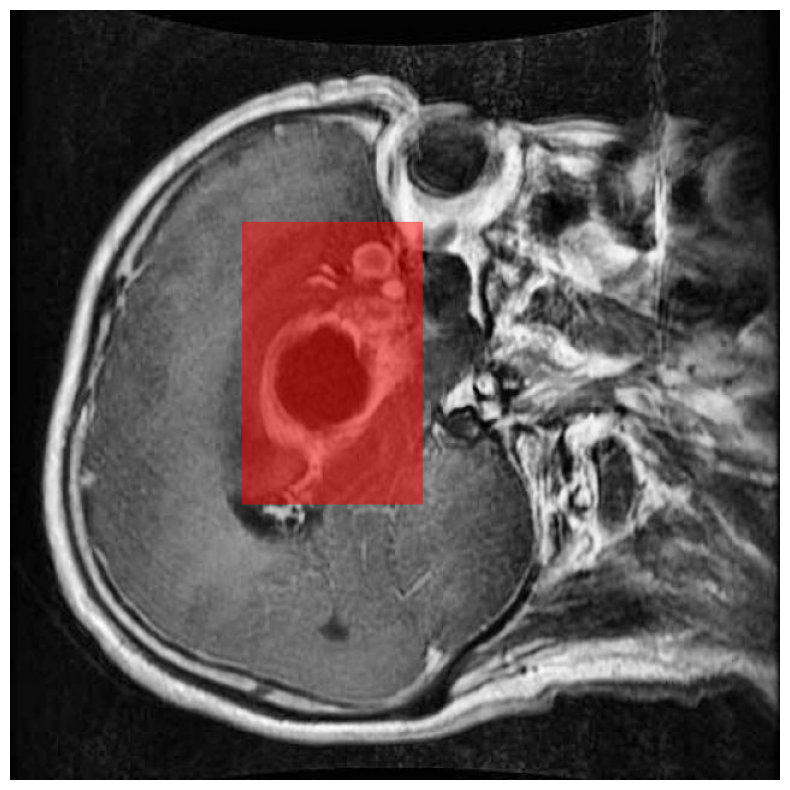

In [10]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Load COCO annotations
def load_coco_annotations(json_path):
    with open(json_path, 'r') as f:
        coco_data = json.load(f)
    
    images = {img['id']: img for img in coco_data['images']}
    annotations = coco_data['annotations']
    categories = {cat['id']: cat['name'] for cat in coco_data['categories']}
    
    return images, annotations, categories

# Define paths
json_path = 'train/_annotations.coco.json'
img_dir = 'train'

# Load annotations
images, annotations, categories = load_coco_annotations(json_path)

# Select a random image
random_img_id = list(images.keys())[1]
img_info = images[random_img_id]
img_path = os.path.join(img_dir, img_info['file_name'])

# Load the image
image = Image.open(img_path).convert("RGB")

# Create an empty mask
mask = Image.new('L', (img_info['width'], img_info['height']), 0)
draw = ImageDraw.Draw(mask)

# Fill the mask with the segmentation annotations
for ann in annotations:
    if ann['image_id'] == random_img_id:
        segmentation = ann['segmentation']
        for seg in segmentation:
            poly = np.array(seg).reshape((len(seg) // 2, 2))
            draw.polygon([tuple(p) for p in poly], outline=1, fill=1)

mask = np.array(mask, dtype=np.uint8)

# Create a red mask
red_mask = Image.new('RGBA', (img_info['width'], img_info['height']), (255, 0, 0, 0))
red_mask_np = np.array(red_mask)
red_mask_np[mask == 1] = [255, 0, 0, 128]  # Red with alpha 128 (semi-transparent)

# Convert image to RGBA
image_rgba = image.convert("RGBA")
image_np = np.array(image_rgba)

# Overlay the red mask on the image
overlay = Image.alpha_composite(image_rgba, Image.fromarray(red_mask_np))

# Plot the image with th

# Plot the image with the segmentation mask
plt.figure(figsize=(10, 10))
plt.imshow(overlay)
plt.axis('off')
plt.show()

In [11]:
# SÄMRE ÄN FÖRSTA MODELLEN -> TA BORT
'''
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
import time
from tqdm import tqdm

class SegNet(nn.Module):
    def __init__(self, num_classes=1):
        super(SegNet, self).__init__()
        
        # Encoder (based on VGG16 without FC layers)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2, return_indices=True),  # Pooling with indices
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2, return_indices=True),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2, return_indices=True)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.MaxUnpool2d(2, stride=2),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.MaxUnpool2d(2, stride=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.MaxUnpool2d(2, stride=2),
            nn.Conv2d(64, num_classes, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # Encoder forward pass with pooling indices
        indices = []
        for layer in self.encoder:
            if isinstance(layer, nn.MaxPool2d):
                x, idx = layer(x)
                indices.append(idx)
            else:
                x = layer(x)

        # Decoder forward pass using stored indices
        for layer in self.decoder:
            if isinstance(layer, nn.MaxUnpool2d):
                x = layer(x, indices.pop())
            else:
                x = layer(x)

        return x

# Instantiate the model
num_classes = 2  # Binary segmentation (tumor vs. non-tumor)
model = SegNet(num_classes=num_classes)
print(model)

# Define the optimizer and loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
criterion = torch.nn.CrossEntropyLoss()

# Set the device to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Transformations
resize_size = (64, 64)
transform_mean = [0.485, 0.456, 0.406]
transform_std = [0.229, 0.224, 0.225]

image_transform = transforms.Compose([
    transforms.Resize(resize_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=transform_mean, std=transform_std)
])

mask_transform = transforms.Compose([
    transforms.Resize(resize_size),
    transforms.ToTensor()
])

# Load COCO annotations
def load_coco_annotations(json_path):
    import json
    with open(json_path, 'r') as f:
        coco_data = json.load(f)

    images = {img['id']: img for img in coco_data['images']}
    annotations = coco_data['annotations']
    categories = {cat['id']: cat['name'] for cat in coco_data['categories']}
    
    return images, annotations, categories

# Paths to training data
train_json_path = 'train/_annotations.coco.json'
train_img_dir = 'train'
train_images, train_annotations, train_categories = load_coco_annotations(train_json_path)

# Define Dataset and DataLoader (assuming BrainData is defined elsewhere)
train_dataset = BrainData(
    train_images, train_annotations, train_img_dir,
    image_transform=image_transform, mask_transform=mask_transform
)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Training loop
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    start_time = time.time()
    
    for images, masks in tqdm(train_dataloader):
        images = images.to(device)
        masks = masks.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        
        # Compute loss
        loss = criterion(outputs, masks)
        epoch_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    # Print epoch statistics
    end_time = time.time()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Time: {end_time - start_time:.2f}s")
'''

'\nimport torch\nimport torch.nn as nn\nimport torchvision\nfrom torch.utils.data import DataLoader\nfrom torchvision import transforms\nimport time\nfrom tqdm import tqdm\n\nclass SegNet(nn.Module):\n    def __init__(self, num_classes=1):\n        super(SegNet, self).__init__()\n        \n        # Encoder (based on VGG16 without FC layers)\n        self.encoder = nn.Sequential(\n            nn.Conv2d(3, 64, kernel_size=3, padding=1),\n            nn.BatchNorm2d(64),\n            nn.ReLU(inplace=True),\n            nn.Conv2d(64, 64, kernel_size=3, padding=1),\n            nn.BatchNorm2d(64),\n            nn.ReLU(inplace=True),\n            nn.MaxPool2d(2, stride=2, return_indices=True),  # Pooling with indices\n            \n            nn.Conv2d(64, 128, kernel_size=3, padding=1),\n            nn.BatchNorm2d(128),\n            nn.ReLU(inplace=True),\n            nn.Conv2d(128, 128, kernel_size=3, padding=1),\n            nn.BatchNorm2d(128),\n            nn.ReLU(inplace=True),\n     

In [12]:
# THE GOOD MODEL
'''
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import DataLoader
from torchvision import transforms
import time
from tqdm import tqdm

class VGG16Backbone(nn.Module):
    def __init__(self):
        super(VGG16Backbone, self).__init__()
        # Load the pretrained VGG16 model and use only the feature extractor part
        vgg16 = models.vgg16(pretrained=True)
        self.features = vgg16.features

        # Modify the last pooling layer to preserve higher resolution
        self.features[30] = nn.Identity()  # Replace the final max-pooling layer

    def forward(self, x):
        return self.features(x)

class DeepLabV3VGG16(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3VGG16, self).__init__()
        # Use the modified VGG16 as the backbone
        self.backbone = VGG16Backbone()

        # ASPP (Atrous Spatial Pyramid Pooling) module
        self.aspp = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=6, dilation=6, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=12, dilation=12, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=18, dilation=18, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # Decoder head to output the segmentation map
        self.classifier = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, num_classes, kernel_size=1)
        )

    def forward(self, x):
        # Extract features with VGG16 backbone
        features = self.backbone(x)

        # Apply ASPP to extracted features
        x = self.aspp(features)

        # Upsample the output to match input size
        x = nn.functional.interpolate(x, size=(64, 64), mode='bilinear', align_corners=False)

        # Generate the final segmentation map
        return self.classifier(x)

# Instantiate the model with 1 output class (binary segmentation)
num_classes = 2  # Binary segmentation: tumor vs background
model = DeepLabV3VGG16(num_classes=num_classes)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define optimizer and loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
criterion = torch.nn.CrossEntropyLoss()

# Define transformations for images and masks
resize_size = (64, 64)
transform_mean = [0.485, 0.456, 0.406]
transform_std = [0.229, 0.224, 0.225]

image_transform = transforms.Compose([
    transforms.Resize(resize_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=transform_mean, std=transform_std)
])

mask_transform = transforms.Compose([
    transforms.Resize(resize_size),
    transforms.ToTensor()
])

# Load COCO annotations
def load_coco_annotations(json_path):
    import json
    with open(json_path, 'r') as f:
        coco_data = json.load(f)

    images = {img['id']: img for img in coco_data['images']}
    annotations = coco_data['annotations']
    categories = {cat['id']: cat['name'] for cat in coco_data['categories']}
    
    return images, annotations, categories

# Load dataset and DataLoader (assuming BrainData is defined)
train_json_path = 'train/_annotations.coco.json'
train_img_dir = 'train'
train_images, train_annotations, train_categories = load_coco_annotations(train_json_path)

train_dataset = BrainData(
    train_images, train_annotations, train_img_dir,
    image_transform=image_transform, mask_transform=mask_transform
)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Training loop
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    start_time = time.time()

    for images, masks in tqdm(train_dataloader):
        images = images.to(device)
        masks = masks.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Compute the loss
        loss = criterion(outputs, masks.long().squeeze(1))
        epoch_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Print epoch statistics
    end_time = time.time()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Time: {end_time - start_time:.2f}s")
'''

'\nimport torch\nimport torch.nn as nn\nfrom torchvision import models\nfrom torch.utils.data import DataLoader\nfrom torchvision import transforms\nimport time\nfrom tqdm import tqdm\n\nclass VGG16Backbone(nn.Module):\n    def __init__(self):\n        super(VGG16Backbone, self).__init__()\n        # Load the pretrained VGG16 model and use only the feature extractor part\n        vgg16 = models.vgg16(pretrained=True)\n        self.features = vgg16.features\n\n        # Modify the last pooling layer to preserve higher resolution\n        self.features[30] = nn.Identity()  # Replace the final max-pooling layer\n\n    def forward(self, x):\n        return self.features(x)\n\nclass DeepLabV3VGG16(nn.Module):\n    def __init__(self, num_classes):\n        super(DeepLabV3VGG16, self).__init__()\n        # Use the modified VGG16 as the backbone\n        self.backbone = VGG16Backbone()\n\n        # ASPP (Atrous Spatial Pyramid Pooling) module\n        self.aspp = nn.Sequential(\n            nn

In [13]:
'''
import torch
import torchvision
from torchvision.models.segmentation import deeplabv3_resnet50
from torch.utils.data import DataLoader
from torchvision import transforms
import time
from tqdm import tqdm

# Define the model
model = deeplabv3_resnet50(pretrained=True)
num_classes = 2  # Example: 1 class (object) + background
model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))

# Define the optimizer and loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
criterion = torch.nn.CrossEntropyLoss()

# Set the device to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

from torchvision import transforms
resize_size=(64,64)
transform_mean = [0.485, 0.456, 0.406]
transform_std = [0.229, 0.224, 0.225]
# Define transformations
image_transform = transforms.Compose([
    transforms.Resize(resize_size),  # Resize images to 256x256
    transforms.ToTensor(),
    transforms.Normalize(mean=transform_mean, std=transform_std)
])

mask_transform = transforms.Compose([
    transforms.Resize(resize_size),  # Resize masks to 256x256
    transforms.ToTensor()
])

# Load COCO annotations
def load_coco_annotations(json_path):
    import json
    with open(json_path, 'r') as f:
        coco_data = json.load(f)
    
    images = {img['id']: img for img in coco_data['images']}
    annotations = coco_data['annotations']
    categories = {cat['id']: cat['name'] for cat in coco_data['categories']}
    
    return images, annotations, categories

from torch.utils.data import DataLoader

# Load COCO annotations
train_json_path = 'train/_annotations.coco.json'
train_img_dir = 'train'
train_images, train_annotations, train_categories = load_coco_annotations(train_json_path)

# Create datasets and dataloaders
train_dataset = BrainData(train_images, train_annotations, train_img_dir, image_transform=image_transform, mask_transform=mask_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
# Training loop
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    start_time = time.time()
    
    for images, masks in tqdm(train_dataloader):
        images = images.to(device)
        masks = masks.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)['out']
        
        # Compute the loss
        loss = criterion(outputs, masks)
        epoch_loss += loss.item()
        
        # Backward pass
        loss.backward()
        optimizer.step()
    
    # Print epoch statistics
    end_time = time.time()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Time: {end_time - start_time:.2f}s")
'''

'\nimport torch\nimport torchvision\nfrom torchvision.models.segmentation import deeplabv3_resnet50\nfrom torch.utils.data import DataLoader\nfrom torchvision import transforms\nimport time\nfrom tqdm import tqdm\n\n# Define the model\nmodel = deeplabv3_resnet50(pretrained=True)\nnum_classes = 2  # Example: 1 class (object) + background\nmodel.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))\n\n# Define the optimizer and loss function\noptimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)\ncriterion = torch.nn.CrossEntropyLoss()\n\n# Set the device to GPU if available\ndevice = torch.device(\'cuda\') if torch.cuda.is_available() else torch.device(\'cpu\')\nmodel.to(device)\n\nfrom torchvision import transforms\nresize_size=(64,64)\ntransform_mean = [0.485, 0.456, 0.406]\ntransform_std = [0.229, 0.224, 0.225]\n# Define transformations\nimage_transform = transforms.Compose([\n    transforms.Resize(resize_size),  # 

In [26]:
'''
import torch
import torch.nn as nn
import time
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import DataLoader

# ===========================
# Patch Embedding, Merging, and Expansion
# ===========================

class PatchEmbedding(nn.Module):
    def __init__(self, in_ch, embed_dim, patch_size):
        super().__init__()
        self.proj = nn.Conv2d(in_ch, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # Input shape: [B, C, H, W]
        x = self.proj(x)  # [B, embed_dim, H/patch_size, W/patch_size]
        x = x.flatten(2).transpose(1, 2)  # [B, (H*W)/patch_size^2, embed_dim]
        return x

class PatchMerging(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.reduction = nn.Linear(4 * dim, 2 * dim)

    def forward(self, x):
        # Input shape: [B, N, C] where N = H*W / patch_size^2
        B, N, C = x.shape
        H = W = int(N ** 0.5)  # Assume input is a square
        x = x.view(B, H, W, C)

        # Merge patches by concatenating 2x2 patches
        x0 = x[:, 0::2, 0::2, :]  # Top-left
        x1 = x[:, 1::2, 0::2, :]  # Bottom-left
        x2 = x[:, 0::2, 1::2, :]  # Top-right
        x3 = x[:, 1::2, 1::2, :]  # Bottom-right

        # Concatenate and reshape
        x = torch.cat([x0, x1, x2, x3], dim=-1)  # [B, H/2, W/2, 4*C]
        x = x.view(B, -1, 4 * C)  # [B, (H*W)/4, 4*C]
        x = self.reduction(x)  # [B, (H*W)/4, 2*C]
        return x

class PatchExpansion(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.expand = nn.Linear(dim, dim * 2)

    def forward(self, x):
        # Input shape: [B, N, C]
        B, N, C = x.shape
        H = W = int(N ** 0.5)  # Assume input is square

        # Expand patches
        x = self.expand(x)  # [B, N, 2*C]
        x = x.view(B, H, W, 2 * C)

        # Rearrange to form expanded patches
        x = x.permute(0, 3, 1, 2)  # [B, 2*C, H, W]
        return x

class FinalPatchExpansion(nn.Module):
    def __init__(self, C):
        super().__init__()
        self.expand = nn.ConvTranspose2d(C, C, kernel_size=2, stride=2)

    def forward(self, x):
        return self.expand(x)

# ===========================
# SwinUNet Model Components
# ===========================

class SwinBlock(nn.Module):
    def __init__(self, dims, ip_res, ss_size=3):
        super().__init__()
        self.swtb1 = SwinTransformerBlock(dim=dims, input_resolution=ip_res)
        self.swtb2 = SwinTransformerBlock(dim=dims, input_resolution=ip_res, shift_size=ss_size)

    def forward(self, x):
        return self.swtb2(self.swtb1(x))


class Encoder(nn.Module):
    def __init__(self, C, partioned_ip_res, num_blocks=3):
        super().__init__()
        H, W = partioned_ip_res
        self.enc_swin_blocks = nn.ModuleList([
            SwinBlock(C, (H, W)),
            SwinBlock(2 * C, (H // 2, W // 2)),
            SwinBlock(4 * C, (H // 4, W // 4))
        ])
        self.enc_patch_merge_blocks = nn.ModuleList([
            PatchMerging(C),
            PatchMerging(2 * C),
            PatchMerging(4 * C)
        ])

    def forward(self, x):
        skip_conn_ftrs = []
        for swin_block, patch_merger in zip(self.enc_swin_blocks, self.enc_patch_merge_blocks):
            x = swin_block(x)
            skip_conn_ftrs.append(x)
            x = patch_merger(x)
        return x, skip_conn_ftrs


class Decoder(nn.Module):
    def __init__(self, C, partioned_ip_res, num_blocks=3):
        super().__init__()
        H, W = partioned_ip_res
        self.dec_swin_blocks = nn.ModuleList([
            SwinBlock(4 * C, (H // 4, W // 4)),
            SwinBlock(2 * C, (H // 2, W // 2)),
            SwinBlock(C, (H, W))
        ])
        self.dec_patch_expand_blocks = nn.ModuleList([
            PatchExpansion(8 * C),
            PatchExpansion(4 * C),
            PatchExpansion(2 * C)
        ])
        self.skip_conn_concat = nn.ModuleList([
            nn.Linear(8 * C, 4 * C),
            nn.Linear(4 * C, 2 * C),
            nn.Linear(2 * C, C)
        ])

    def forward(self, x, encoder_features):
        for patch_expand, swin_block, enc_ftr, linear_concatter in zip(
                self.dec_patch_expand_blocks, self.dec_swin_blocks, encoder_features, self.skip_conn_concat):
            x = patch_expand(x)
            x = torch.cat([x, enc_ftr], dim=-1)
            x = linear_concatter(x)
            x = swin_block(x)
        return x


class SwinUNet(nn.Module):
    def __init__(self, H, W, ch, C, num_class, num_blocks=3, patch_size=4):
        super().__init__()
        self.patch_embed = PatchEmbedding(ch, C, patch_size)
        self.encoder = Encoder(C, (H // patch_size, W // patch_size), num_blocks)
        self.bottleneck = SwinBlock(C * (2 ** num_blocks), 
                                    (H // (patch_size * (2 ** num_blocks)), 
                                     W // (patch_size * (2 ** num_blocks))))
        self.decoder = Decoder(C, (H // patch_size, W // patch_size), num_blocks)
        self.final_expansion = FinalPatchExpansion(C)
        self.head = nn.Conv2d(C, num_class, 1, padding='same')

    def forward(self, x):
        x = self.patch_embed(x)
        x, skip_ftrs = self.encoder(x)
        x = self.bottleneck(x)
        x = self.decoder(x, skip_ftrs[::-1])
        x = self.final_expansion(x)
        x = self.head(x.permute(0, 3, 1, 2))  # [B, H, W, C] -> [B, C, H, W]
        return x

# ==============================
# Data Processing and Training
# ==============================

# Set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Initialize the model
H, W, ch, C, num_class = 64, 64, 3, 96, 2  # Adjust according to your data
model = SwinUNet(H, W, ch, C, num_class).to(device)

# Define optimizer and loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
criterion = torch.nn.CrossEntropyLoss()

# Define data transformations
resize_size = (64, 64)
transform_mean = [0.485, 0.456, 0.406]
transform_std = [0.229, 0.224, 0.225]

image_transform = transforms.Compose([
    transforms.Resize(resize_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=transform_mean, std=transform_std)
])

mask_transform = transforms.Compose([
    transforms.Resize(resize_size),
    transforms.ToTensor()
])

# Function to load COCO annotations
def load_coco_annotations(json_path):
    import json
    with open(json_path, 'r') as f:
        coco_data = json.load(f)
    images = {img['id']: img for img in coco_data['images']}
    annotations = coco_data['annotations']
    categories = {cat['id']: cat['name'] for cat in coco_data['categories']}
    return images, annotations, categories

# Load training data annotations
train_json_path = 'train/_annotations.coco.json'
train_img_dir = 'train'
train_images, train_annotations, train_categories = load_coco_annotations(train_json_path)

# Custom dataset class (assuming you have BrainData defined)
train_dataset = BrainData(train_images, train_annotations, train_img_dir, 
                          image_transform=image_transform, mask_transform=mask_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Training loop
num_epochs = 1  # Adjust as needed

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    start_time = time.time()

    for images, masks in tqdm(train_dataloader):
        images, masks = images.to(device), masks.to(device)

        # Remove extra channel dimension from masks if necessary
        if masks.dim() == 4 and masks.size(1) == 1:
            masks = masks.squeeze(1)  # [B, 1, H, W] -> [B, H, W]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)  # [B, num_classes, H, W]

        # Compute loss
        loss = criterion(outputs, masks)  # Ensure masks are [B, H, W]
        epoch_loss += loss.item()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

    # Print epoch statistics
    end_time = time.time()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Time: {end_time - start_time:.2f}s")
'''

Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


  0%|                                                                                          | 0/376 [00:00<?, ?it/s]


RuntimeError: Tensors must have same number of dimensions: got 4 and 3

In [29]:
# NEW

class PatchMerging(nn.Module):

    def __init__(
            self,
            dim
    ):
        super().__init__()
        self.norm = nn.LayerNorm(4 * dim)
        self.reduction = nn.Linear(4*dim, 2*dim, bias=False)

    def forward(self, x):
        B, H, W, C = x.shape
        x = x.reshape(B, H // 2, 2, W // 2, 2, C).permute(0, 1, 3, 4, 2, 5).flatten(3)
        x = self.norm(x)
        x = self.reduction(x)
        return x

class PatchExpansion(nn.Module):

    def __init__(
            self,
            dim
    ):
        super().__init__()
        self.norm = nn.LayerNorm(dim//2)
        self.expand = nn.Linear(dim, 2*dim, bias=False)

    def forward(self, x):

        x = self.expand(x)
        B, H, W, C = x.shape

        x = x.view(B, H , W, 2, 2, C//4)
        x = x.permute(0,1,3,2,4,5)

        x = x.reshape(B,H*2, W*2 , C//4)

        x = self.norm(x)
        return x

class SwinBlock(nn.Module):
    def __init__(self, dims, ip_res, ss_size = 3):
        super().__init__()
        self.swtb1 = SwinTransformerBlock(dim=dims, input_resolution=ip_res)
        self.swtb2 = SwinTransformerBlock(dim=dims, input_resolution=ip_res, shift_size=ss_size)

    def forward(self, x):
        return self.swtb2(self.swtb1(x))


class Encoder(nn.Module):
    def __init__(self, C, partioned_ip_res, num_blocks=3):
        super().__init__()
        H,W = partioned_ip_res[0], partioned_ip_res[1]
        self.enc_swin_blocks = nn.ModuleList([
            SwinBlock(C, (H, W)),
            SwinBlock(2*C, (H//2, W//2)),
            SwinBlock(4*C, (H//4, W//4))
        ])
        self.enc_patch_merge_blocks = nn.ModuleList([
            PatchMerging(C),
            PatchMerging(2*C),
            PatchMerging(4*C)
        ])

    def forward(self, x):
        skip_conn_ftrs = []
        for swin_block,patch_merger in zip(self.enc_swin_blocks, self.enc_patch_merge_blocks):
            x = swin_block(x)
            skip_conn_ftrs.append(x)
            x = patch_merger(x)
        return x, skip_conn_ftrs


class Decoder(nn.Module):
    def __init__(self, C, partioned_ip_res, num_blocks=3):
        super().__init__()
        H,W = partioned_ip_res[0], partioned_ip_res[1]
        self.dec_swin_blocks = nn.ModuleList([
            SwinBlock(4*C, (H//4, W//4)),
            SwinBlock(2*C, (H//2, W//2)),
            SwinBlock(C, (H, W))
        ])
        self.dec_patch_expand_blocks = nn.ModuleList([
            PatchExpansion(8*C),
            PatchExpansion(4*C),
            PatchExpansion(2*C)
        ])
        self.skip_conn_concat = nn.ModuleList([
            nn.Linear(8*C, 4*C),
            nn.Linear(4*C, 2*C),
            nn.Linear(2*C, 1*C)
        ])

    def forward(self, x, encoder_features):
        for patch_expand,swin_block, enc_ftr, linear_concatter in zip(self.dec_patch_expand_blocks, self.dec_swin_blocks, encoder_features,self.skip_conn_concat):
            x = patch_expand(x)
            x = torch.cat([x, enc_ftr], dim=-1)
            x = linear_concatter(x)
            x = swin_block(x)
        return x


class SwinUNet(nn.Module):
    def __init__(self, H, W, ch, C, num_class, num_blocks=3, patch_size = 4):
        super().__init__()
        self.patch_embed = PatchEmbedding(ch, C, patch_size)
        self.encoder = Encoder(C, (H//patch_size, W//patch_size),num_blocks)
        self.bottleneck = SwinBlock(C*(2**num_blocks), (H//(patch_size* (2**num_blocks)), W//(patch_size* (2**num_blocks))))
        self.decoder = Decoder(C, (H//patch_size, W//patch_size),num_blocks)
        self.final_expansion = FinalPatchExpansion(C)
        self.head        = nn.Conv2d(C, num_class, 1,padding='same')

    def forward(self, x):
        x = self.patch_embed(x)

        x,skip_ftrs  = self.encoder(x)

        x = self.bottleneck(x)

        x = self.decoder(x, skip_ftrs[::-1])

        x = self.final_expansion(x)

        x = self.head(x.permute(0,3,1,2))

        return x

# ----------------------------------------------------------------------------------------------------------

# Set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Initialize the model
H, W, ch, C, num_class = 64, 64, 3, 96, 2  # Adjust according to your data
model = SwinUNet(H, W, ch, C, num_class).to(device)

# Define optimizer and loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
criterion = torch.nn.CrossEntropyLoss()

# Define data transformations
resize_size = (64, 64)
transform_mean = [0.485, 0.456, 0.406]
transform_std = [0.229, 0.224, 0.225]

image_transform = transforms.Compose([
    transforms.Resize(resize_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=transform_mean, std=transform_std)
])

mask_transform = transforms.Compose([
    transforms.Resize(resize_size),
    transforms.ToTensor()
])

# Function to load COCO annotations
def load_coco_annotations(json_path):
    import json
    with open(json_path, 'r') as f:
        coco_data = json.load(f)
    images = {img['id']: img for img in coco_data['images']}
    annotations = coco_data['annotations']
    categories = {cat['id']: cat['name'] for cat in coco_data['categories']}
    return images, annotations, categories

# Load training data annotations
train_json_path = 'train/_annotations.coco.json'
train_img_dir = 'train'
train_images, train_annotations, train_categories = load_coco_annotations(train_json_path)

# Custom dataset class (assuming you have BrainData defined)
train_dataset = BrainData(train_images, train_annotations, train_img_dir, 
                          image_transform=image_transform, mask_transform=mask_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Training loop
num_epochs = 1  # Adjust as needed

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    start_time = time.time()

    for images, masks in tqdm(train_dataloader):
        images, masks = images.to(device), masks.to(device)

        # Remove extra channel dimension from masks if necessary
        if masks.dim() == 4 and masks.size(1) == 1:
            masks = masks.squeeze(1)  # [B, 1, H, W] -> [B, H, W]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)  # [B, num_classes, H, W]

        # Compute loss
        loss = criterion(outputs, masks)  # Ensure masks are [B, H, W]
        epoch_loss += loss.item()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

    # Print epoch statistics
    end_time = time.time()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Time: {end_time - start_time:.2f}s")


  0%|                                                                                          | 0/376 [00:00<?, ?it/s]


ValueError: not enough values to unpack (expected 4, got 3)

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Function to reverse normalization
def denormalize(image, mean, std):
    image = image * std + mean
    return image

# Function to overlay masks on images
def overlay_mask_on_image(image, mask, color=(255, 0, 0), alpha=0.5):
    image = image.convert("RGBA")
    overlay = Image.new("RGBA", image.size, color + (0,))
    mask = mask.convert("L")
    overlay.paste(Image.new("RGBA", image.size, color + (int(255 * alpha),)), mask)
    return Image.alpha_composite(image, overlay)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..1.7511113].


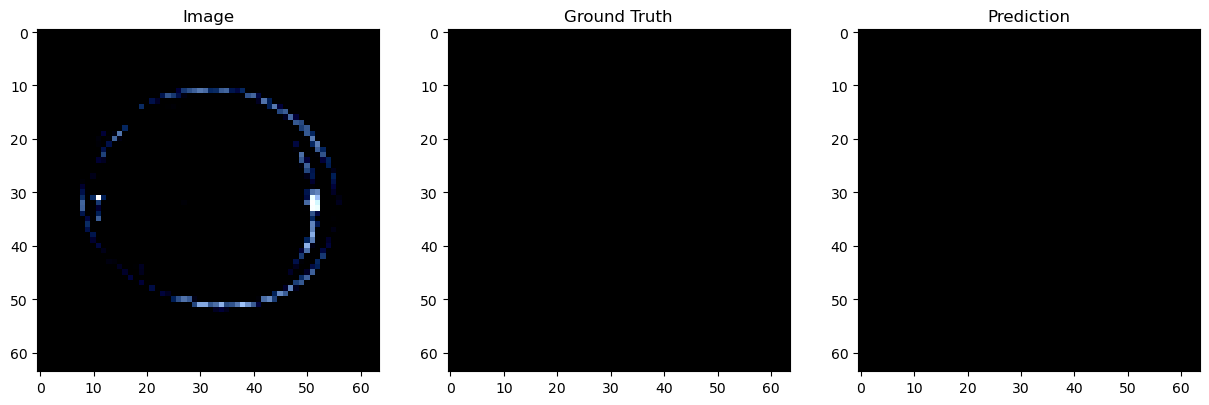

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.0648367].


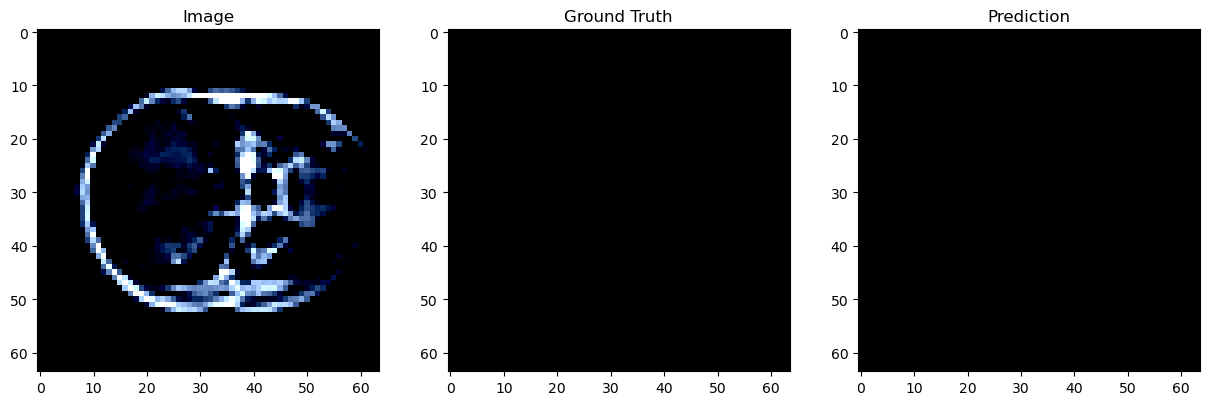

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..1.8556864].


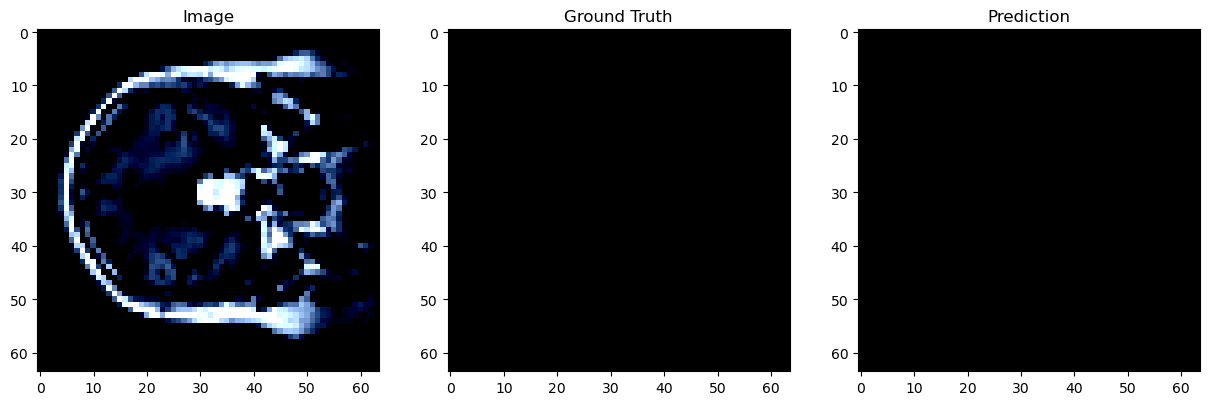

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.0474076].


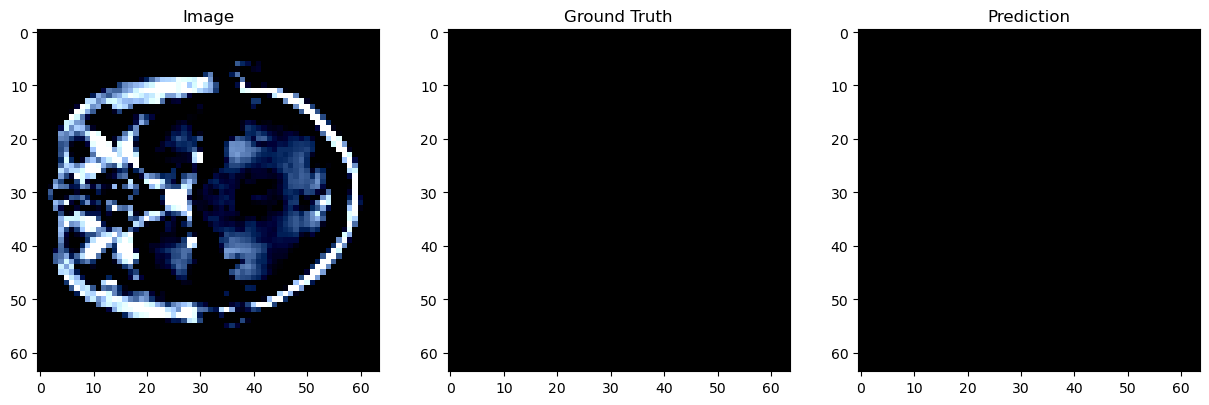

In [13]:
import matplotlib.pyplot as plt

# Function to plot predictions and ground truth
def plot_predictions(images, masks, predictions):
    batch_size = images.size(0)
    for i in range(batch_size):
        image = images[i].cpu().numpy().transpose(1, 2, 0)
        mask = masks[i].cpu().numpy()
        prediction = predictions[i].cpu().numpy()
        
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(image)
        ax[0].set_title('Image')
        ax[1].imshow(mask, cmap='gray')
        ax[1].set_title('Ground Truth')
        ax[2].imshow(prediction, cmap='gray')
        ax[2].set_title('Prediction')
        plt.show()

# Test loop
model.eval()
with torch.no_grad():
    for images, masks in val_dataloader:
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass
        outputs = model(images)['out']
        predictions = torch.argmax(outputs, dim=1)
        
        # Plot predictions and ground truth
        plot_predictions(images, masks, predictions)
        break  # Remove this break to plot all batches